# Content and Objective

+ Show estimation of psd w. Welch
+ Method: Get noise, filtered noise and sinusoid, and perform psd estimation

In [7]:
# importing
import numpy as np
from scipy import signal
import scipy as sp

import matplotlib.pyplot as plt
import matplotlib

# showing figures inline
%matplotlib inline

In [8]:
# plotting options 
font = {'size'   : 30}
plt.rc('font', **font)
plt.rc('text', usetex=True)

matplotlib.rc('figure', figsize=(30, 8) )

# Helper Functions

### Functions for estimating spectra 

In [9]:
########################
# periodogram estimator
########################
def find_periodogram(y, omega):
    """
    estimates periodogram out of the given observation at the frequencies specified in omega
    
    IN: observation y, frequencies
    OUT: psd estimator
    """
    N = len(y)
    per = np.zeros(len(omega), dtype=complex) 
        
    for p in np.arange(0, N):
        per += y[p] * np.exp( -1j * omega * (p+1) )
        
    per = ( abs(per)**2 )/ N
        
    return per  


########################
# Welch periodogram estimator
########################
def find_welch_estimate(y, M, O, omega, window=[]):
    """
    estimates periodogram out of the given observation at the frequencies specified in omega
    using Welch's method
    
    IN: observation y, group size M, overlap O, frequencies Omega, 
        window of length M chosen as rect if not specified otherwise
    OUT: psd estimator
    """
    
    N = len(y)
    K = int( N / (M-O) )
    
    per = np.zeros(len(omega))
    
    if len(window)==0:
        window = np.ones(M)
    
    window = window / (1.0/M * np.sum(window**2))

    # loop for segments    
    k = 0
    while k<K-1:        
        yk = y[ k*(M-O) : (k*(M-O)+M) ] # mind that the upper limit is not included        
        yk = yk * window        
    

        
        Yk = find_periodogram(yk, omega)

        per = 1.0/(k+1) * ( k*per + Yk )  

        k += 1            

    return per    

# Parameters

In [10]:
# parameters: number of samples and according length of acf
N = int( 1e3 )
#N = int( 1e4 )
N_range = np.arange( 0, N )

# width of segments and overlap
M = N // 10
#M = N // 100
O = M // 2

#window = []
window = signal.windows.blackman(M)

# number of realizations for averaging    
N_real = int( 1e2 )

# number of freq. points and freq. range
N_freq = 512            
Ome = np.linspace(-np.pi, np.pi, N_freq)


# filtering noise?!
filtered = 1

# Loop for realizations

In [11]:
# initialize arrays for psd
psd_noise_per = np.empty( [ N_real, N_freq ], dtype=float )
psd_noise_welch = np.empty( [ N_real, N_freq ], dtype=float )

psd_sin_per = np.empty( [ N_real, N_freq ], dtype=float )
psd_sin_welch = np.empty( [ N_real, N_freq ], dtype=float )

# avtivate parameter "filtered" in parameters if you like to see filtered noise
if filtered == 1:
    # filter parameters
    cutoff_freq = 1.0/4.0

    ripple_db = 60                      # ripples and transition width of the filter
    width = 1 / 5.0

    N_filter, beta = signal.kaiserord(ripple_db, width)    # find filter order and beta parameter
    
    taps = signal.firwin( N_filter, cutoff=cutoff_freq,  window=('kaiser', beta))

    
# loop for realizations
for _k in range( N_real ):
    
    # generate noise
    noise = np.sqrt(2) * np.random.normal( 0.0, 1.0, N )

    # activate to have filtered noise
    if filtered == 1:
        noise = signal.lfilter( taps, 1.0, noise )   
        noise /= np.linalg.norm( noise )

    # find estimations
    psd_noise_per[ _k, :] = find_periodogram( noise, Ome )      
    psd_noise_welch[ _k, :] = find_welch_estimate( noise, M, O, Ome ,window )


    Omega_0 = 1.0
    Omega_1 = 1.2
    y = np.sin( Omega_0 * N_range ) + np.sin( Omega_1 * N_range)  + np.random.normal(0.0, 1.0, size = N)

    psd_sin_per[ _k, :] = find_periodogram( y, Ome )      
    psd_sin_welch[ _k, :] = find_welch_estimate( y, M, O, Ome, window )        
        
        
        
# get mean and std along realizations
psd_noise_per_average = psd_noise_per.mean( axis=0 )  
psd_noise_per_tria_std = psd_noise_per.std( axis=0 )  

psd_noise_welch_average = psd_noise_welch.mean( axis=0 )   
psd_noise_welch_std = psd_noise_welch.std( axis=0 )   


psd_sin_per_average = psd_sin_per.mean( axis=0 )  
psd_sin_per_tria_std = psd_sin_per.std( axis=0 )  

psd_sin_welch_average = psd_sin_welch.mean( axis=0 )   
psd_sin_welch_std = psd_sin_welch.std( axis=0 )   


# Plotting

<>:10: SyntaxWarning: invalid escape sequence '\h'
<>:20: SyntaxWarning: invalid escape sequence '\h'
<>:33: SyntaxWarning: invalid escape sequence '\h'
<>:43: SyntaxWarning: invalid escape sequence '\h'
<>:10: SyntaxWarning: invalid escape sequence '\h'
<>:20: SyntaxWarning: invalid escape sequence '\h'
<>:33: SyntaxWarning: invalid escape sequence '\h'
<>:43: SyntaxWarning: invalid escape sequence '\h'
/tmp/ipykernel_3802/693532393.py:10: SyntaxWarning: invalid escape sequence '\h'
  plt.ylabel('$\hat{\Phi}_p(\Omega)$')
/tmp/ipykernel_3802/693532393.py:20: SyntaxWarning: invalid escape sequence '\h'
  plt.ylabel('$\hat{\Phi}_W(\Omega)$')
/tmp/ipykernel_3802/693532393.py:33: SyntaxWarning: invalid escape sequence '\h'
  plt.ylabel('$\hat{\Phi}_p(\Omega)$')
/tmp/ipykernel_3802/693532393.py:43: SyntaxWarning: invalid escape sequence '\h'
  plt.ylabel('$\hat{\Phi}_W(\Omega)$')


Text(0, 0.5, '$\\hat{\\Phi}_W(\\Omega)$')

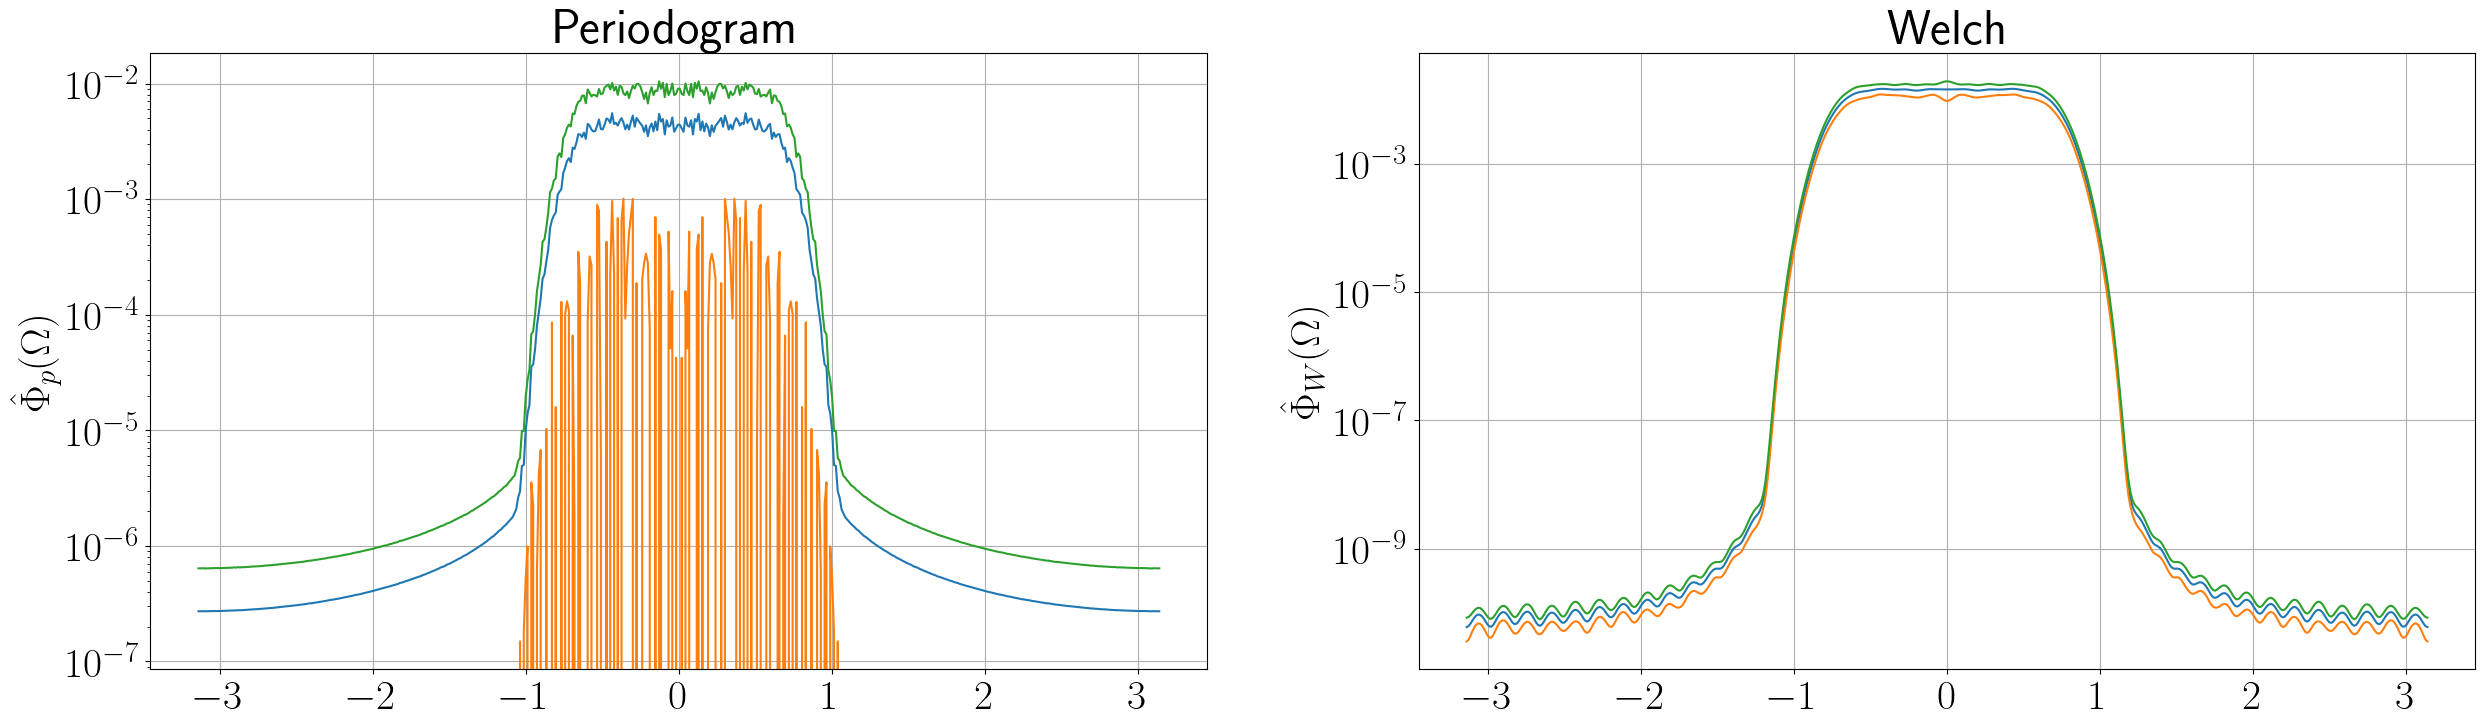

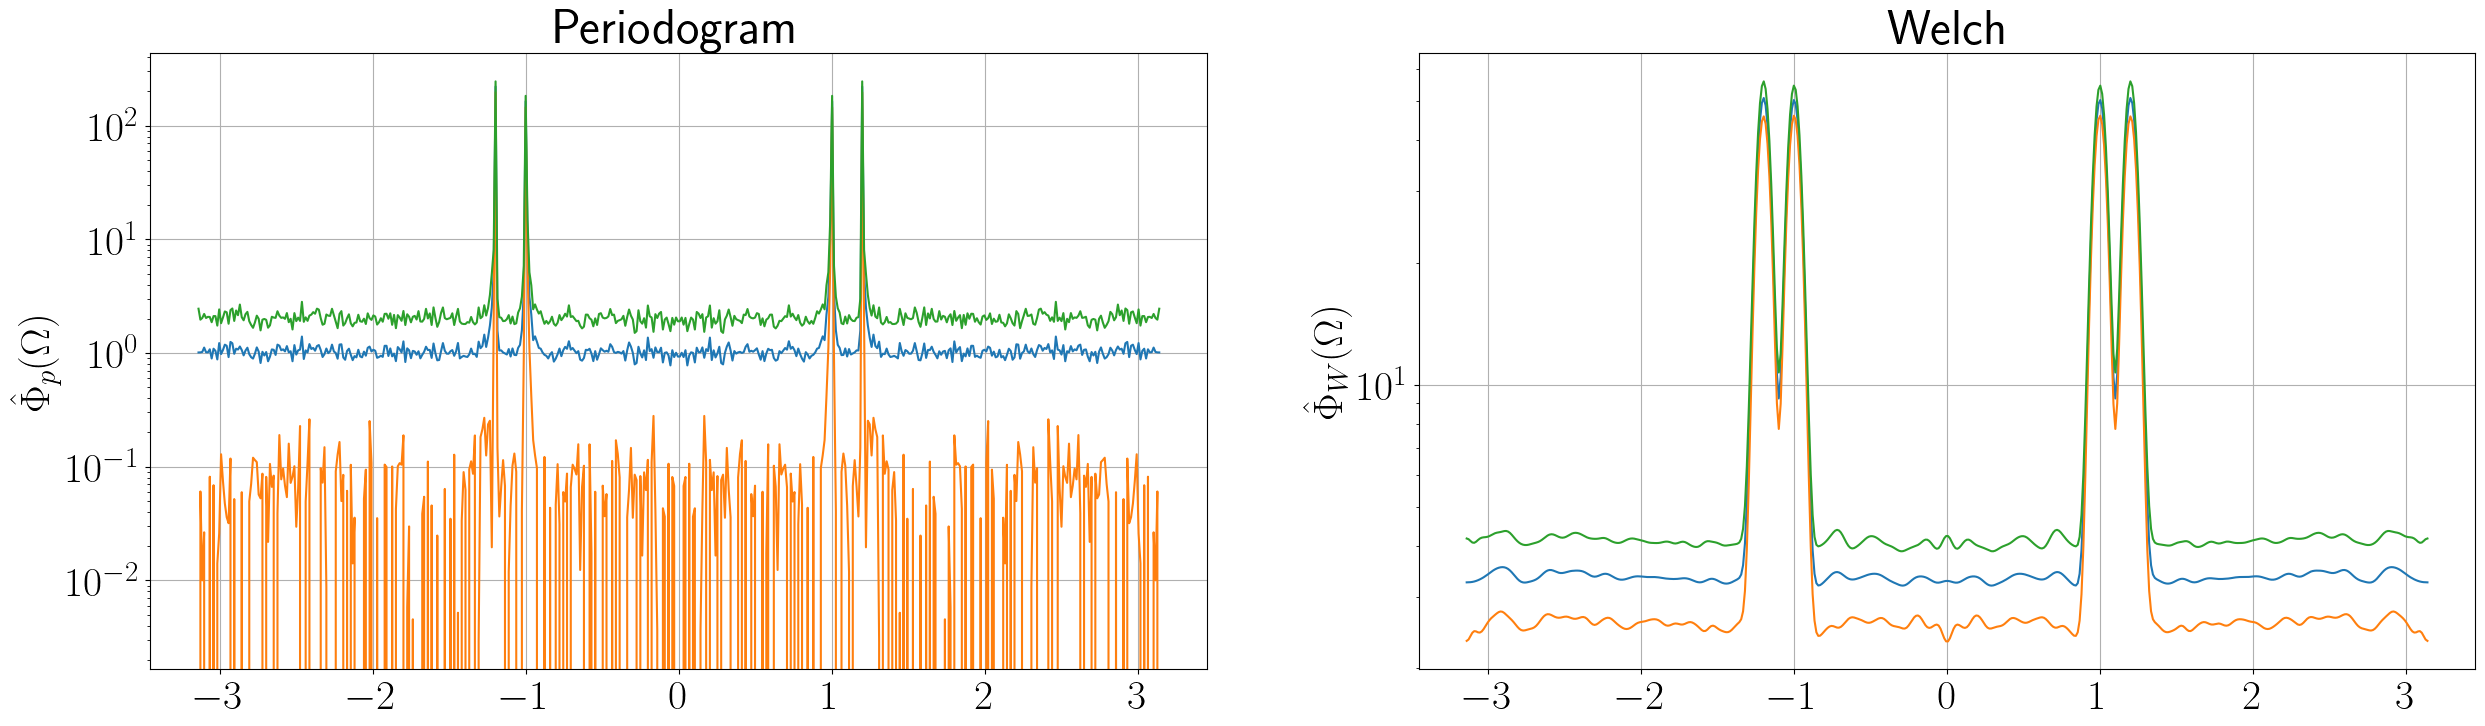

In [12]:
plt.figure()

plt.subplot(121)    
plt.semilogy(Ome, psd_noise_per_average)      
plt.semilogy(Ome, psd_noise_per_average - psd_noise_per_tria_std)          
plt.semilogy(Ome, psd_noise_per_average + psd_noise_per_tria_std)  

plt.title('Periodogram')    
plt.grid(True); 
plt.ylabel('$\hat{\Phi}_p(\Omega)$')   


plt.subplot(122)    
plt.semilogy(Ome, psd_noise_welch_average)      
plt.semilogy(Ome, psd_noise_welch_average - psd_noise_welch_std)          
plt.semilogy(Ome, psd_noise_welch_average + psd_noise_welch_std)  

plt.title('Welch')    
plt.grid(True); 
plt.ylabel('$\hat{\Phi}_W(\Omega)$')   



plt.figure()

plt.subplot(121)    
plt.semilogy(Ome, psd_sin_per_average)      
plt.semilogy(Ome, psd_sin_per_average - psd_sin_per_tria_std)          
plt.semilogy(Ome, psd_sin_per_average + psd_sin_per_tria_std)  

plt.title('Periodogram')    
plt.grid(True); 
plt.ylabel('$\hat{\Phi}_p(\Omega)$')   


plt.subplot(122)    
plt.semilogy(Ome, psd_sin_welch_average)      
plt.semilogy(Ome, psd_sin_welch_average - psd_sin_welch_std)          
plt.semilogy(Ome, psd_sin_welch_average + psd_sin_welch_std)  

plt.title('Welch')    
plt.grid(True); 
plt.ylabel('$\hat{\Phi}_W(\Omega)$')   